In [110]:
### resize images
from keras.preprocessing.image import load_img,img_to_array
import numpy as np
import pandas as pd
import cv2
import glob
df = pd.read_csv('balanced_cars.csv')
df['label']=df['is_premium'].map(lambda x: 1 if x==True else 0)
print(df.head())

                          car_url_id  is_premium  label
0   2010-xuefolan-lechi-d77BsJBbW9uE       False      0
1  2009-fengtian-weichi-dIIJBBIhZZWZ       False      0
2      2014-MINI-COOPER-dB7k0BBZ9XbX        True      1
3         2013-aodi-A4L-dBs0iJQXuXwX        True      1
4    2009-kaidilake-CTS-d00QkBJbwwhN        True      1


In [112]:
x=[]
y=[]
#for i in range(len(df)):
for i in range(len(df)):
    car_url_id = df.loc[i,'car_url_id']
    #replace the extension from .png to .txt
    image_file_name = '{}.png'.format(car_url_id)
    
    #if the file already processed, skip to next
    exist = glob.glob('extracted_vgg/{}.txt'.format(car_url_id))
    if(len(exist)>0):
        print('this file already processed: {}, skip to next.'.format(image_file_name))
        continue
    
    if i %50 ==0:
        print('Processing {}'.format(i), image_file_name)
    #print('extracted_vgg/{}'.format(image_file_name))
   
    try:
        #read the image file and resize it to 227 x 227
        img = load_img('aug_img2/{}'.format(image_file_name),target_size=(240, 240))
        img1 = img_to_array(img)
        x.append(img1)
        y.append(df.loc[i,'label'])
        #img2 = load_img('aug_img2/{}_aug.png'.format(image_file_name),target_size=(224, 224))
        #print(img1.shape, img2.shape)
    except:
        print('img not found :', image_file_name, ' : ',img)
        
x = np.array(x)
y = np.array(y)
print(y)

Processing 0 2010-xuefolan-lechi-d77BsJBbW9uE.png
Processing 50 2012-sikeda-mingrui-dB7BVQQbWXbb.png
Processing 100 2016-aodi-A3sanxiang-d0IJiIBuNEwZ.png
Processing 150 2012-sikeda-rui-ysBJI7wXNZWN.png
Processing 200 2013-baoma-1xi-dB7sBVIZZwhE.png
Processing 250 2005-baoma-3xi-dsI0VskbwWuE.png
Processing 300 2009-leikesasi-ES-dJkI7BsbWbww.png
Processing 350 2017-kaidilake-XTS-dB7BsIkX9EXW.png
Processing 400 2011-richan-yangguang-dIBJQIVwEZhZ.png
Processing 450 2008-dazhong-POLOliangxiang-d70J0VJWwwhW.png
Processing 500 2013-dazhong-jieda-ysQ77JZwbZ9N.png
Processing 550 2011-benchi-Eji-d00BJ7B9NZZN.png
Processing 600 2016-dazhong-POLOliangxiang-d0ks0i7ZwwNW.png
Processing 650 2013-benchi-Cji-dkV07isZ99ZE.png
Processing 700 2012-aodi-A4L-d0sVV0BWuuhN.png
Processing 750 2011-baoma-3xi-dIkQQQiZZN9X.png
Processing 800 2017-fute-ruijie-dBsVVIBuNNNw.png
Processing 850 2007-qirui-A5-ds7Js7ihNhZW.png
Processing 900 2012-beijing-Exilieliangxiang-GVQIQEWXNEWZ.png
Processing 950 2009-leikesasi-ES

In [114]:
#### split the data
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(x[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (2406, 240, 240, 3)
y_train (2406,)
x_test (601, 240, 240, 3)
y_test (601,)


In [115]:
### easy model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(240, 240,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [116]:
batch_size = 32
epochs = 5

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning_test.model', monitor='val_acc', save_best_only=True)]
)

##50 epochs, 5 hours
##accuracy: loss: 0.6788 - acc: 0.5842 - val_loss: 0.6760 - val_acc: 0.57 

#history.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/5
18/75 [======>.......................] - ETA: 11:03 - loss: 7.8899 - acc: 0.4861

KeyboardInterrupt: 

In [42]:
### baseline first model, 3 convulational layers with Relu activation followed by max pooling, dropout to reduce overfitting

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 238, 238, 32)      896       
_________________________________________________________________
activation_3 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 117, 117, 32)      9248      
_________________________________________________________________
activation_4 (Activation)    (None, 117, 117, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
__________

In [67]:
from sklearn.metrics import classification_report, confusion_matrix

#Y_pred = model.predict(x_test)
#print(Y_pred)

rounded = [round(x[0]) for x in Y_pred]
#print(rounded)
#print(y_test)

#y_pred = np.argmax(Y_pred, axis=1)
#print('Confusion Matrix')
print(confusion_matrix(y_test, rounded))
print('Classification Report')
print(classification_report(y_test, rounded))


[[409   0]
 [  0 192]]
Classification Report
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       409
        1.0       1.00      1.00      1.00       192

avg / total       1.00      1.00      1.00       601



dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


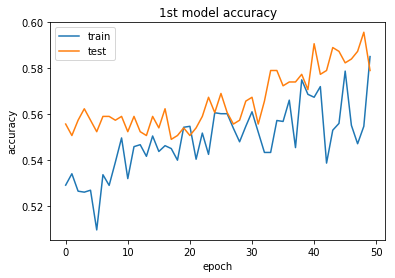

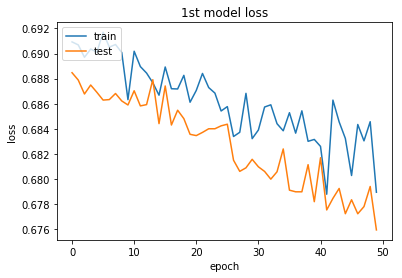

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('1st model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('1st model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the plot of loss, we can see that the model has comparable performance on both train and validation datasets (labeled test).

### Pre-trained network VGG16

In [3]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

Using TensorFlow backend.


In [4]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense


add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))

model_vgg = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model_vgg.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [80]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_datagen.fit(x_train)


history_vgg = model_vgg.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning_2.model', monitor='val_acc', save_best_only=True)]
)

Epoch 1/50
75/75 [==============================] - 5016s 67s/step - loss: 1.1654 - acc: 0.5171 - val_loss: 0.6995 - val_acc: 0.5241
Epoch 2/50
75/75 [==============================] - 5121s 68s/step - loss: 0.6939 - acc: 0.5208 - val_loss: 0.6906 - val_acc: 0.5391
Epoch 3/50
75/75 [==============================] - 4498s 60s/step - loss: 0.6919 - acc: 0.5414 - val_loss: 0.7132 - val_acc: 0.5275
Epoch 4/50
75/75 [==============================] - 4467s 60s/step - loss: 0.6881 - acc: 0.5461 - val_loss: 0.6990 - val_acc: 0.5424
Epoch 5/50
75/75 [==============================] - 4484s 60s/step - loss: 0.6885 - acc: 0.5464 - val_loss: 0.6815 - val_acc: 0.5458
Epoch 6/50
75/75 [==============================] - 4460s 59s/step - loss: 0.6728 - acc: 0.5838 - val_loss: 0.6840 - val_acc: 0.5740
Epoch 7/50
75/75 [==============================] - 4460s 59s/step - loss: 0.6712 - acc: 0.5927 - val_loss: 0.6607 - val_acc: 0.6240
Epoch 8/50
75/75 [==============================] - 4460s 59s/step - 

KeyboardInterrupt: 

In [83]:
import matplotlib.pyplot as plt
print(history_vgg.history.keys())
# summarize history for accuracy
plt.plot(history_vgg.history['acc'])
plt.plot(history_vgg.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history_vgg' is not defined

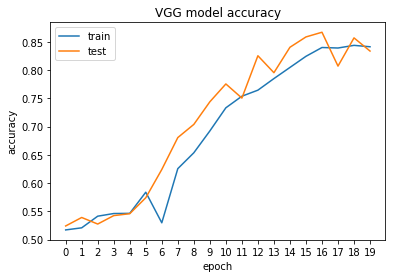

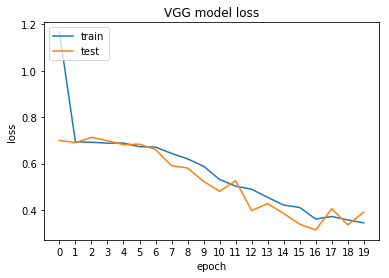

In [97]:
### 36 hours for 20 epochs vgg net

acc=[0.5171,0.5208,0.5414,0.5461,0.5464,0.5838,0.5297,0.6255,0.6536,0.6922,0.7332,0.7537,0.7644,0.7849,0.8046,0.8243,0.8399,0.8390,0.8437,0.8412]
loss=[1.1654,0.6939,0.6919,0.6881,0.6885,0.6728,0.6712,0.6439,0.6204,0.5890,0.5319,0.5031,0.4899,0.4549,0.4217,0.4113,0.3617,0.3725,0.3578,0.3453]
acc_val=[0.5241,0.5391,0.5275,0.5424,0.5458,0.5740,0.6240,0.6805,0.7038,0.7438,0.7754,0.7504,0.8253,0.7953,0.8403,0.8586,0.8669,0.8070,0.8569,0.8336]
loss_val=[0.6995,0.6906,0.7132,0.6990,0.6815,0.6840,0.6607,0.5911,0.5810,0.5237,0.4812,0.5268,0.3983,0.4280,0.3856,0.3394,0.3148,0.4062,0.3367,0.3909]
epoch=[int(i) for i in range(0,20)]

# summarize history for accuracy
plt.plot(epoch,acc)
plt.plot(epoch,acc_val)
plt.title('VGG model accuracy')
plt.xticks(epoch)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(epoch,loss)
plt.plot(epoch,loss_val)
plt.title('VGG model loss')
plt.xticks(epoch)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()